In [1]:
# script to compare SSA/equivalent diameter from CT and integrating spheres
from read_CT_txt_files import read_CT_txt_files
from average_CT_data import average_CT_data

import matplotlib.pyplot as plt
import numpy as np

from snowexsql.db import get_db
from snowexsql.data import LayerData, PointData
from snowexsql.conversions import points_to_geopandas, query_to_geopandas

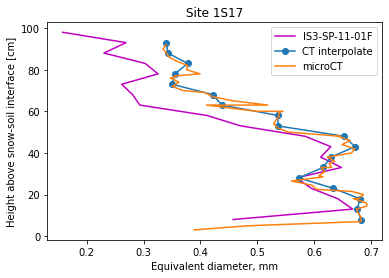

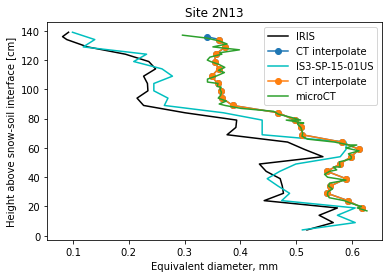

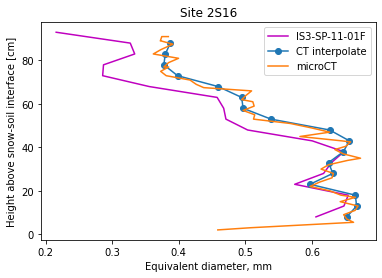

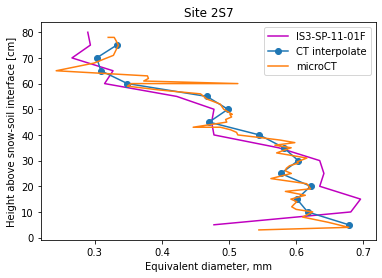

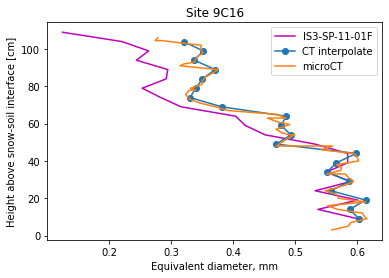

In [7]:
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine_is, session_is = get_db(db_name)

# Establish plot colors unique to the instrument
c = ['k', 'm', 'c']

instruments=['IRIS', 'IS3-SP-11-01F', 'IS3-SP-15-01US']

colors = {inst:c[i] for i,inst in enumerate(instruments)}

Deq_CT_all=np.array([])
Deq_IS_all=np.array([])

sites=['1S17','2N13','2S16','2S7','9C16']
for site in sites:
    data_dir='../data/microCT/' + site + '/'
    [SSA_CT,height_min,height_max]=read_CT_txt_files(data_dir)
    height_CT_avg=0.5*(height_min+height_max)
    
    q_is = session_is.query(LayerData).filter(LayerData.type == 'specific_surface_area').filter(LayerData.site_id.contains(site) )
    df_is = query_to_geopandas(q_is, engine_is)
    instruments_site = df_is['instrument'].unique()

    fig,ax = plt.subplots()

    # plot all instruments at this site
    for instr in instruments_site:

        # Grab our profile by site and instrument
        ind = df_is['instrument'] == instr
        profile = df_is.loc[ind].copy()    

        # Don't plot it unless there is data
        if len(profile.index) > 0:

            # Sort by depth so samples that are take out of order won't mess up the plot
            profile = profile.sort_values(by='depth')

            # Layer profiles are always stored as strings. 
            profile['value'] = 6/917/profile['value'].astype(float)*1000
            
            ssa_CT_i = average_CT_data(height_CT_avg,SSA_CT,profile['depth'].to_numpy())            

            # Plot our profile
            ax.plot(profile['value'], profile['depth'], colors[instr], label=instr)
            ax.plot(6/917/ssa_CT_i*1000, profile['depth'], label='CT interpolate',marker='o')
            
            Deq_CT_all=np.append(Deq_CT_all,6/917/ssa_CT_i*1000)
            Deq_IS_all=np.append(Deq_IS_all,profile['value'])
            

    ax.plot(6/917/SSA_CT*1000,height_min,label='microCT')        #CT data
    
    ax.set_xlabel('Equivalent diameter, mm')
    ax.set_ylabel('Height above snow-soil interface [cm]')
    ax.legend()

    ax.set_title(f'Site {site.upper()}')        
    plt.show()

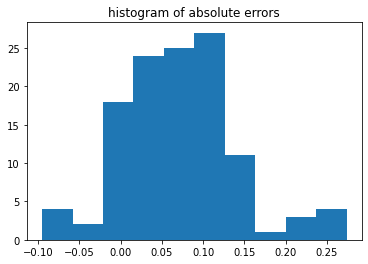

In [16]:
Deq_diff=Deq_CT_all-Deq_IS_all
Deq_diff_good=Deq_diff[~np.isnan(Deq_diff)]

plt.hist(Deq_diff_good, bins='auto') 
plt.title('histogram of absolute errors')
plt.show()

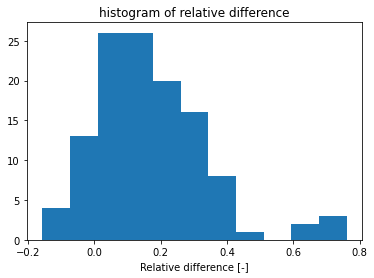

In [32]:
Deq_diff_rel=Deq_diff/Deq_CT_all

Deq_diff_rel_good=Deq_diff_rel[~np.isnan(Deq_diff_rel)]

plt.hist(Deq_diff_rel_good , bins='auto') 
plt.title('histogram of relative difference')
plt.xlabel('Relative difference [-]')
plt.show()

In [21]:
np.mean(Deq_diff_rel_good)

0.1710381146481095

In [22]:
np.std(Deq_diff_rel_good)

0.1704283839579078

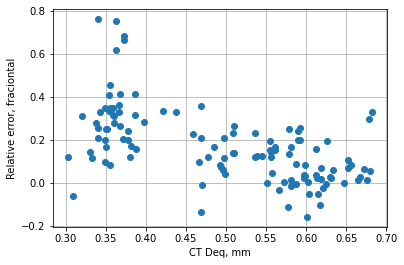

In [27]:
fig,ax = plt.subplots()
ax.plot(Deq_CT_all,Deq_diff_rel,marker='o',linestyle='none')
ax.set_xlabel('CT Deq, mm')
ax.set_ylabel('Relative error, fraciontal')
plt.grid()
plt.show()

In [28]:
len(Deq_diff_rel_good)

119